In [29]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
import matplotlib.pyplot as plt
import requests
import gdown
import zipfile
import gzip
import shutil
import cv2
from PIL import Image
import math


# Downloading the training and validation data

We use the Automated Cardiac Diagnosis Challenge database. https://acdc.creatis.insa-lyon.fr/#challenges
After signing up the training and validation datasets are available to download. The databases contain a total of 150 MRI scans from different patient, some healthy and some with different conditions.

In [2]:
training_url = 'https://drive.google.com/u/0/uc?id=1FTUNw1gIYjIphJBfF9p-cAEa2fZVz76G&export=download'
training_output = 'training.zip'
testing_url = 'https://drive.google.com/uc?id=1GBSeFwhOutknsu8IBqvjcjdXbjNUF1P5&export=download'
testing_output = 'testing.zip'

#Download the zips from the given urls
gdown.download(training_url, training_output, quiet=False, verify=False)
gdown.download(testing_url, testing_output, quiet=False, verify=False)

C:\Users\levi2\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\levi2\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
C:\Users\levi2\AppData\Roaming\Python\Python310\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drive.google.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn

'testing.zip'

Unzip the training and testing datasets and the scans in them into the train_valid/patients directory.

In [3]:
os.mkdir('train_valid')

with zipfile.ZipFile('training.zip', 'r') as zip_ref:
    zip_ref.extractall('train_valid')

with zipfile.ZipFile('testing.zip', 'r') as zip_ref:
    zip_ref.extractall('train_valid')

os.mkdir('./train_valid/patients')
os.remove("./train_valid/training/patient001.Info.cfg")
shutil.rmtree("./train_valid/testing/testing")

for subdir in os.listdir("./train_valid/training"):
  with gzip.open(f"./train_valid/training/{subdir}/{subdir}_4d.nii.gz", "rb") as f_in:
    with open(f"./train_valid/patients/{subdir}.nii", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

for subdir in os.listdir("./train_valid/testing"):
  with gzip.open(f"./train_valid/testing/{subdir}/{subdir}_4d.nii.gz", "rb") as f_in:
    with open(f"./train_valid/patients/{subdir}.nii", 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

shutil.rmtree("./train_valid/training")
shutil.rmtree("./train_valid/testing")

# Dissect the 3D scans into 2D images

The scans come as 4D objects, 3D MRI scans over some time. We unroll the scans into 2D images and add them to an original_images folder. The images will be the reference for the super resolution images.

In [32]:
os.mkdir('./train_valid/original_images')
all_scans = []

for file in os.listdir("./train_valid/patients"):
    img=nib.load(f'./train_valid/patients/{file}')
    
    all_scans.append(img)

    img_data = img.get_fdata()

    #there may be larger images than 256 right now we just throw those away
    if img_data.shape[0] <= 256 and img_data.shape[1] <= 256:
        for i in range(img.shape[2]):
            for j in range(img.shape[3]):
                expanded_image = img_data[:, :, i, j]

                x_diff = (256 - expanded_image.shape[1]) // 2
                y_diff = (256 - expanded_image.shape[0]) // 2

                expanded_image = np.pad(expanded_image, ((y_diff, y_diff), (x_diff, x_diff)), 'constant')

                plt.imsave(f'./train_valid/original_images/{file[:-4]}_{i}_{j}.png', expanded_image)

print(len(all_scans))

150


Here we create different scaled down version of the images. These will be used to train the network.

In [ ]:
os.mkdir('./train_valid/90percent_scale')
os.mkdir('./train_valid/80percent_scale')
os.mkdir('./train_valid/75percent_scale')
os.mkdir('./train_valid/60percent_scale')
os.mkdir('./train_valid/50percent_scale')

for file in os.listdir('./train_valid/original_images'):
    img = plt.imread(f'./train_valid/original_images/{file}')
    scaled_to_90 = cv2.resize(img, dsize=(230, 230))
    scaled_to_80 = cv2.resize(img, dsize=(204, 204))
    scaled_to_75 = cv2.resize(img, dsize=(192, 192))
    scaled_to_60 = cv2.resize(img, dsize=(153, 153))
    scaled_to_50 = cv2.resize(img, dsize=(128, 128))


    plt.imsave(f'./train_valid/90percent_scale/90_{file}', scaled_to_90)
    plt.imsave(f'./train_valid/80percent_scale/80_{file}', scaled_to_80)
    plt.imsave(f'./train_valid/75percent_scale/75_{file}', scaled_to_75)
    plt.imsave(f'./train_valid/60percent_scale/60_{file}', scaled_to_60)
    plt.imsave(f'./train_valid/50percent_scale/50_{file}', scaled_to_50)

    break

(192, 192)


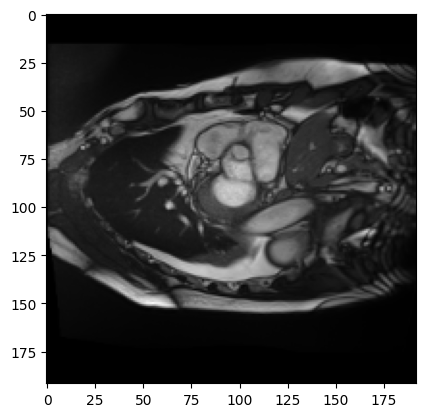

In [27]:
# lower=cv2.pyrDown(img_data, dstsize=(128, 128))
lower=cv2.resize(img_data, dsize=(192, 192))

plt.imshow(lower, cmap='gray')
print(lower.shape)

In [30]:
np.random.seed(2812)

train_split = 0.7
validate_split = 0.2
test_split = 0.1


dataset_path = './train_valid/90percent_scale'
dataset_size = len(os.listdir(dataset_path))

train_size = math.ceil(train_split * dataset_size)
validate_size = int(validate_split * dataset_size)
test_size = int(dataset_size - train_size - validate_size)


training_data=[]
validation_data=[]
test_data = []

for i, file in enumerate(os.listdir(dataset_path)):
  image = plt.imread(f'{dataset_path}/{file}')
  if i < train_size:
    training_data.append(image)
  elif i < validate_size:
    validation_data.append(image)
  else:
    test_data.append(image)


IndentationError: expected an indented block after 'if' statement on line 21 (3721027020.py, line 25)

In [ ]:
print('training data set size:', len(training_data), len(training_data[0]))
print('validation data set size:', len(validation_data), len(validation_data[0]))
print('test data set size:', len(test_data), len(test_data[0]))

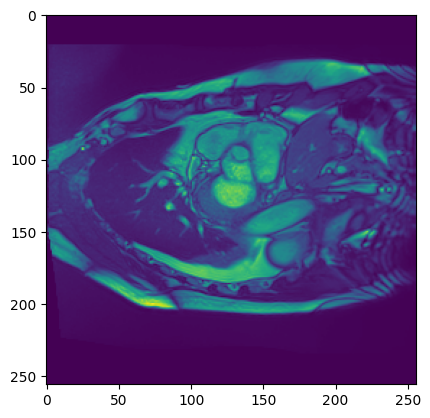

In [15]:
image_path = "./train_valid/original_images/patient001_0_0.png"
image_file = Image.open(image_path)
image_file.save("90.png", quality=90)
image_file.save("50.png", quality=50)
image_file.save("75.png", quality=75)
image_file.save("25.png", quality=25)
image_file.save("1.png", quality=1)

plt.imshow(plt.imread("./1.png"))

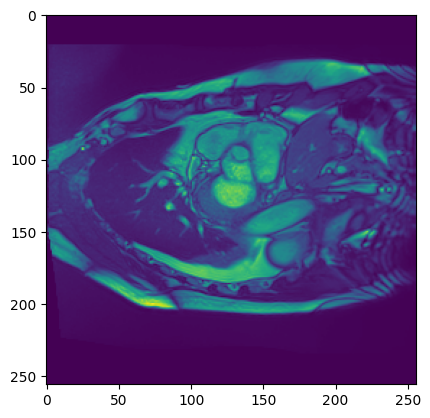

In [11]:
plt.imshow(plt.imread("./train_valid/original_images/patient001_0_0.png"))